# Intelligent Data Analysis Project
### Matej Bebej (50%), Marian Kurcina (50%)

## Table of Contents
- Assignment
- Phase 3 – Machine Learning
  - 3.1 Simple Classifier Based on Data Dependencies
    - A - Implementation of the ID3 Classifier
    - B - Evaluation of the ID3 Classifier (Accuracy, Precision, Recall)
    - C - Overfitting Analysis for the ID3 Classifier
  - 3.2 Training and Evaluation of Machine-Learning Classifiers
    - A - Training a Tree-Based Classifier Using Scikit-Learn
    - B - Comparison With a Non-Tree-Based Classifier
    - C - Comparison With the Custom ID3 Classifier
    - D - Visualization of Learned Rules
    - E - Evaluation of All Models (Accuracy, Precision, Recall)
  - 3.3 Hyperparameter Tuning and Model Optimization
    - A - Hyperparameter Tuning for the Selected Algorithm
    - B - Ensemble Methods for Performance Optimization
    - C - Cross-Validation on the Training Set
    - D - Demonstrating That the Final Model Is Not Overfitting
  - 3.4 Evaluation of the Strategy’s Impact on Classification
    - A - Impact of Data Preprocessing Strategies
    - B - Impact of Data Transformations (Scaling, transformer, etc.)
    - C - Impact of Feature Selection, Algorithm Choice, Tuning, and Ensembles
    - D - Selection of the Best Model for Deployment
    - E - Final Production Data Pipeline for the Best Model

# Assignment

Oxygen saturation is a key indicator of the proper functioning of the respiratory and circulatory systems. When its value drops to a critically low level, it may indicate life-threatening conditions such as hypoxemia, respiratory failure, or severe infections. In such cases, immediate intervention is essential. Traditional monitoring is performed using pulse oximeters, which, however, can be affected by noise, motion artifacts, or may have limitations in certain clinical situations.

Modern machine learning–based approaches offer the possibility to estimate and predict critical oxygen saturation values with higher accuracy (critical oxygen saturation estimation). Models can utilize multimodal data, such as heart rate, respiratory rate, blood pressure, or sensor signals. By being trained on diverse datasets, it is possible to identify early warning signs of desaturation, filter out noise, and provide timely alerts even before oxygen saturation drops below a safe threshold.

The goal of this assignment is to become familiar with the issue of oxygen saturation monitoring, understand the contribution of artificial intelligence, and design a solution that could improve critical care and reduce risks associated with undiagnosed hypoxemia.

Each pair of students will work with an assigned dataset starting from Week 2. Your task is to predict the dependent variable “oximetry” (the predicted variable) using machine learning methods. In doing so, you will need to deal with various issues present in the data, such as inconsistent formats, missing values, outliers, and others.

The expected outcomes of the project are:

- the best-performing machine learning model, and

- a data pipeline for building it from the input data.

# Phase 3 – Machine Learning

In [36]:
from tools.DropColumns import drop_columns
from tools.DropNa import drop_na
from tools.ParseLocation import ParseLocation
from tools.EnforceSchema import EnforceSchema
from tools.EnforceValueRanges import EnforceValueRanges
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import pandas as pd
import random
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer,PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFE
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_text
import matplotlib.pyplot  as plt
from sklearn.model_selection import GridSearchCV
import os
SEED = 33
random.seed(SEED)
np.random.seed(SEED)


When performing data analysis, our goal may not only be to extract knowledge from the current dataset but also to train a model that can make reasonable predictions for new observations using machine learning techniques.

<br><br>

## 3.1 Simple Classifier Based on Data Dependencies

### A - Implementation of the ID3 Classifier

Implement a simple ID3 classifier with a minimum depth of 2 (including the root).

<br>

Our used ID3Classifier is a simplified decision-tree model based on the ID3 algorithm, adapted to work with numeric features. Because ID3 normally handles only categorical data, this version finds the best numeric split by testing several possible thresholds and choosing the one with the highest information gain. Labels are encoded as integers so entropy and information gain can be computed.

The tree is built recursively: if all samples share the same class or the maximum depth is reached, the algorithm stops and returns the majority class. Otherwise, it splits the data at the best feature/threshold and builds the left and right subtrees. During prediction, the classifier moves through the tree by comparing feature values to the stored thresholds until it reaches a leaf, then returns the corresponding class label.

In [2]:
class ID3Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, min_depth=2, max_depth=None):
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.tree = None
        self.majority_class = None
        self.label_map = {}

    def encode_labels(self, y):
        unique = np.unique(y)
        self.label_map = {c: i for i, c in enumerate(unique)}
        inv_map = {i: c for c, i in self.label_map.items()}
        y_encoded = np.array([self.label_map[val] for val in y])
        return y_encoded, inv_map

    def entropy(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def information_gain(self, y, left, right):
        if len(left) == 0 or len(right) == 0:
            return 0
            
        total_entropy = self.entropy(y)

        n = len(y)
        
        weighted = (len(left)/n)*self.entropy(left) + (len(right)/n)*self.entropy(right)
        return total_entropy - weighted

    def best_split(self, X, y):
        """Find best numeric split: (feature, threshold, gain)."""
        best_gain = -1
        best_feature = None
        best_threshold = None

        for col in range(X.shape[1]):
            values = X[:, col]

            # sorted unique thresholds
            uniq = np.unique(values)
            
            if len(uniq) < 2:
                continue

            thresholds = np.percentile(values, np.linspace(0, 100, min(10, len(np.unique(values)))))

            for t in thresholds:
                left_mask = values <= t
                right_mask = values > t

                gain = self.information_gain(
                    y,
                    y[left_mask],
                    y[right_mask]
                )
                if gain > best_gain:
                    best_gain = gain
                    best_feature = col
                    best_threshold = t

        return best_feature, best_threshold, best_gain

    def build_tree(self, X, y, depth):
        # If all same class
        if len(np.unique(y)) == 1:
            return int(y[0])

        # Max depth reached → majority
        if self.max_depth is not None and depth >= self.max_depth:
            return Counter(y).most_common(1)[0][0]

        feature, threshold, gain = self.best_split(X, y)

        if feature is None or gain <= 0:
            return Counter(y).most_common(1)[0][0]

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        return {
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth+1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth+1)
        }

    def predict_single(self, x):
        node = self.tree

        while isinstance(node, dict):
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node

    def fit(self, X, y):
        X = np.array(X)  # convert to NumPy
        y_encoded, self.inv_label_map = self.encode_labels(y)
        self.tree = self.build_tree(X, y_encoded, depth=1)
        return self

    def predict(self, X):
        X = np.array(X)
        encoded = np.array([self.predict_single(row) for row in X])
        return np.array([self.inv_label_map[i] for i in encoded])


This is just our pipeline we have used at the end of phase_2. To this we will attach our ID3 classifier later on.

In [3]:
observation_schema = {
    'SpO₂':'float',
    'HR':'float',
    'PI':'float',
    'RR':'float',
    'EtCO₂':'float',
    'FiO₂':'float',
    'PRV':'float',
    'BP':'float',
    'Skin Temperature':'float',
    'Motion/Activity index':'float',
    'PVI':'float',
    'Hb level':'float',
    'SV':'float',
    'CO':'float',
    'Blood Flow Index':'float',
    'PPG waveform features':'float',
    'Signal Quality Index':'float',
    'Respiratory effort':'float',
    'O₂ extraction ratio':'float',
    'SNR':'float',
    'oximetry':'int',
    'latitude':'float',
    'longitude':'float'
}

valid_ranges = {
    'SpO₂': (95, 100),
    'HR': (60, 100),
    'PI': (0.2, 20),
    'RR': (12, 20),
    'EtCO₂': (35, 45),
    'FiO₂': (21, 100),
    'PRV': (20, 200),
    'BP': (60, 120),
    'Skin Temperature': (33, 38),
    'Motion/Activity index': None,
    'PVI': (10, 20),
    'Hb level': (12, 18),
    'SV': (60, 100),
    'CO': (4, 8),
    'Blood Flow Index': None,
    'PPG waveform features': None,
    'Signal Quality Index': (0, 100),
    'Respiratory effort': None,
    'O₂ extraction ratio': (0.2, 3),
    'SNR': (20, 40)
}

def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    #("poly", PolynomialFeatures(degree=2, include_bias=False)),
    #("scaler", StandardScaler()),
    ("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),

    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),

    ("variance_threshold", VarianceThreshold(threshold=0.01).set_output(transform="pandas")),
    ("select_kbest", SelectKBest(score_func=f_regression, k=10).set_output(transform="pandas")) 
    #("RFE", RFE(SVR(kernel="linear"), n_features_to_select=10, step=1).set_output(transform="pandas")) 
])

observation = pd.read_csv("dataset/observation.csv", sep='\t')

before = len(observation)
observation = observation.drop_duplicates()
after = len(observation)
print("Removed duplicates:", before - after)

X = observation.drop(columns=["oximetry"])
y = observation["oximetry"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("train shape:", X_train.shape)
print("train shape:", y_train.shape)
print("test shape:", X_test.shape)
print("test shape:", y_test.shape)


Removed duplicates: 1
train shape: (9684, 22)
train shape: (9684,)
test shape: (2422, 22)
test shape: (2422,)


### B - Evaluation of the ID3 Classifier (Accuracy, Precision, Recall)

Evaluate your ID3 classifier using the metrics accuracy, precision, and recall.

<br>

Here, we add id3 clasifier to the end of our pipeline, after operiations such as scaling and transformations. At the end we also provide evalution in form of parameters: accuracy, precision and recall.

Accuracy measures how many predictions the model got right out of all predictions.

Precision (with average='weighted') measures how often the model is correct when it predicts a certain class, while accounting for class imbalance.

Recall (also weighted) measures how well the model finds all examples of each class, again adjusted for class imbalance.

In [4]:
id3 = ID3Classifier(min_depth=2, max_depth=8)

id3_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("id3", id3)
])

id3_pipeline.fit(X_train, y_train)
y_pred = id3_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("evaluation od ID3 classifier")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")

evaluation od ID3 classifier
Accuracy:  0.8860
Precision: 0.8858
Recall:    0.8860
F1-score: 0.8858423666966148


C:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


This code generates a confusion matrix to visualize how well the classifier performed on each class. First, it retrieves the original class labels from the ID3 model. Then it computes the confusion matrix using the true labels (y_test) and the predicted labels (y_pred). Finally, ConfusionMatrixDisplay is used to plot the matrix with a blue color scale, making it easy to see where the model is predicting correctly and where it is making mistakes.

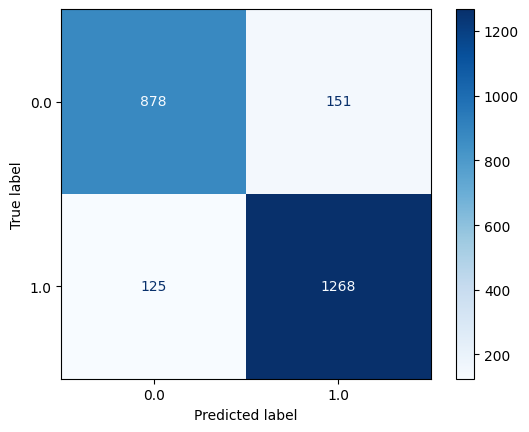

In [5]:
id3_step = id3_pipeline.named_steps['id3']

labels = list(id3_step.inv_label_map.values())  

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')


### C - Overfitting Analysis for the ID3 Classifier

Determine whether your ID3 classifier is overfitting. If it is, fix the overfitting.

<br>

We do the same operations on train_part of data, as we did with test ones. Comparison between results we get is necessary for us to be sure that our model is not overfitting. That we could dtermine by the difference between train adn test performace. Based on this we can safely say that our model is not overfitting (they should have similiar values, train sample should provide us with a better results but not by much).

In [6]:
y_pred = id3_pipeline.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred)
train_precision = precision_score(y_train, y_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)

print("train performace")
print(f"Accuracy:  {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1:        {f1:.4f}")

C:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


train performace
Accuracy:  0.9105
Precision: 0.9106
Recall:    0.9105


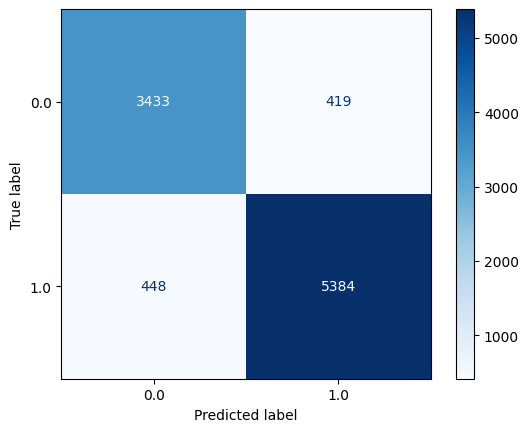

In [7]:
id3_step = id3_pipeline.named_steps['id3']

labels = list(id3_step.inv_label_map.values())  

cm = confusion_matrix(y_train, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

## 3.2 Training and Evaluation of Machine-Learning Classifiers

### A - Training a Tree-Based Classifier Using Scikit-Learn

In [8]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    random_state=SEED
)

dt_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("dt", dt)
])

dt_pipeline.fit(X_train, y_train)
y_pred = dt_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("===== DECISION TREE EVALUATION =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")

===== DECISION TREE EVALUATION =====
Accuracy:  0.8745
Precision: 0.8743
Recall:    0.8745
F1-score: 0.8743849705239377


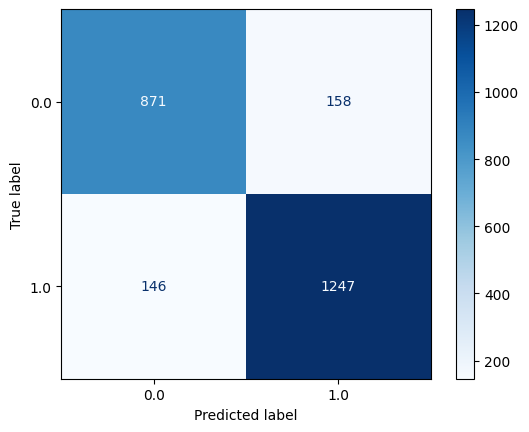

In [9]:
dt_step = dt_pipeline.named_steps['dt']

labels = sorted(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=SEED
)

rf_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("rf", rf)
])

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("===== RANDOM FOREST EVALUATION =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")

===== RANDOM FOREST EVALUATION =====
Accuracy:  0.9026
Precision: 0.9024
Recall:    0.9026
F1-score: 0.9024563256333529


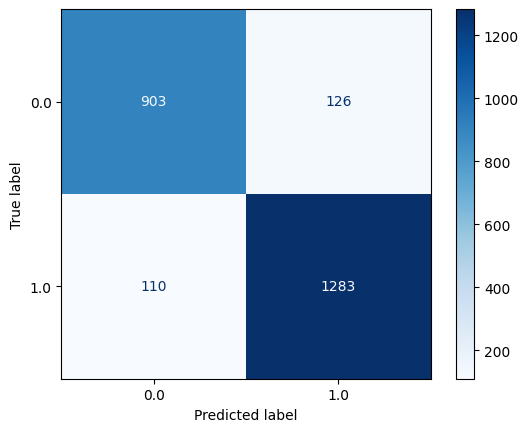

In [11]:
rf_step = rf_pipeline.named_steps['rf']

labels = sorted(set(y_test))  
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

In [12]:
y_pred = rf_pipeline.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred)
train_precision = precision_score(y_train, y_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)

print("train performace")
print(f"Accuracy:  {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")


train performace
Accuracy:  0.9340
Precision: 0.9340
Recall:    0.9340


### B - Comparison With a Non-Tree-Based Classifier

We have decided to use for our Non-Tree algorithm LogisticRegression and kNN clustering classifier.

In [13]:
logreg = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=SEED
)

logreg_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("logreg", logreg)
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("===== LOGISTIC REGRESSION EVALUATION =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")

===== LOGISTIC REGRESSION EVALUATION =====
Accuracy:  0.8055
Precision: 0.8049
Recall:    0.8055
F1-score: 0.8049663080481787


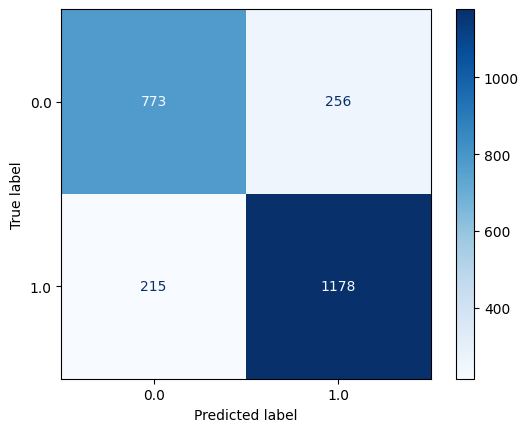

In [14]:
logreg_step = logreg_pipeline.named_steps['logreg']

labels = sorted(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

In [15]:
knn = KNeighborsClassifier(
    n_neighbors=2,
    weights='distance',
)

knn_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("knn", knn)
])

knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("===== KNN CLASSIFIER EVALUATION =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")

===== KNN CLASSIFIER EVALUATION =====
Accuracy:  0.8555
Precision: 0.8553
Recall:    0.8555
F1-score: 0.8553577084488083


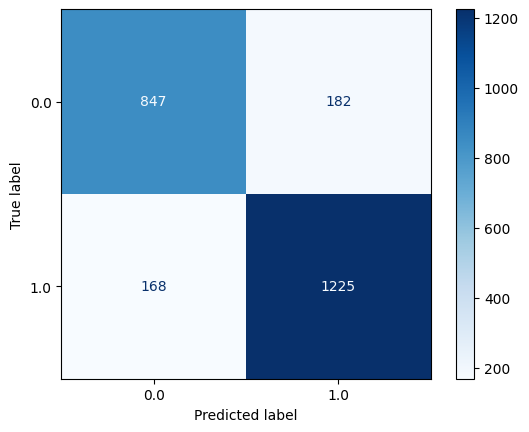

In [16]:
knn_step = knn_pipeline.named_steps['knn']

labels = sorted(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')


### C - Comparison With the Custom ID3 Classifier

Across all evaluated models, Logistic Regression achieved the lowest performance, with accuracy, precision, and recall around 0.81. This is expected, since it is a linear model and may struggle with more complex, nonlinear patterns in the data. 

The kNN classifier did only slightly better then Logistic Regression, with accuracy, precision and recall around 0.84. 

The standard Decision Tree performed better, reaching values around 0.87, showing that tree-based models can capture more complex relationships than linear methods.

The best performing was Random Forest Classifier with accuracy, precision and recall around 0.90, which is much higher then any other model, this will be the model we will be continuing our developnment on.

The ID3 classifier achieved metrics around 0.887, indicating that it fits the structure of the dataset especially well. Its higher accuracy, precision, and recall suggest it is more effective at capturing the underlying decision rules compared to both the logistic model, the regular decision tree and KNN classifier.

Overall, Random Forest Classifier provided the strongest performance among the tested algorithms.

### D - Visualization of Learned Rules

In [17]:
X_transformed = observation_pipeline.transform(X_train)
feature_names = X_transformed.columns.tolist()

def print_rules(tree, feature_names, inv_label_map, depth=0):
    indent = "  " * depth
    
    if not isinstance(tree, dict):
        print(indent + "→ Predict:", inv_label_map[tree])
        return
    
    feat = feature_names[tree["feature"]]
    thr = tree["threshold"]

    print(indent + f"If {feat} <= {thr:.4f}:")
    print_rules(tree["left"], feature_names, inv_label_map, depth+1)

    print(indent + f"Else (if {feat} > {thr:.4f}):")
    print_rules(tree["right"], feature_names, inv_label_map, depth+1)

id3_step = id3_pipeline.named_steps["id3"]

print_rules(id3_step.tree, feature_names, id3_step.inv_label_map)

If num__RR <= 0.0314:
  If num__SpO₂ <= -0.2038:
    If num__SpO₂ <= -0.2867:
      If num__RR <= -0.1757:
        If num__SpO₂ <= -0.3346:
          If num__BP <= -0.1317:
            If num__SpO₂ <= -0.4165:
              → Predict: 0.0
            Else (if num__SpO₂ > -0.4165):
              → Predict: 0.0
          Else (if num__BP > -0.1317):
            If num__Signal Quality Index <= -0.0529:
              → Predict: 0.0
            Else (if num__Signal Quality Index > -0.0529):
              → Predict: 0.0
        Else (if num__SpO₂ > -0.3346):
          If num__PVI <= -0.3050:
            If num__RR <= -0.5154:
              → Predict: 1.0
            Else (if num__RR > -0.5154):
              → Predict: 0.0
          Else (if num__PVI > -0.3050):
            If num__PVI <= 0.0271:
              → Predict: 0.0
            Else (if num__PVI > 0.0271):
              → Predict: 0.0
      Else (if num__RR > -0.1757):
        If num__EtCO₂ <= 0.2161:
          If num__EtCO₂ <= 0.05

In [18]:
X_transformed = observation_pipeline.transform(X_train)
feature_names = X_transformed.columns.tolist()

tree = rf_step.estimators_[0]

tree_text = export_text(tree, feature_names=feature_names)
print(tree_text)

|--- num__SpO₂ <= -0.03
|   |--- num__Signal Quality Index <= 0.45
|   |   |--- num__SpO₂ <= -0.14
|   |   |   |--- num__EtCO₂ <= -0.12
|   |   |   |   |--- num__PVI <= -0.48
|   |   |   |   |   |--- num__HR <= -0.07
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- num__HR >  -0.07
|   |   |   |   |   |   |--- num__SpO₂ <= -0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- num__SpO₂ >  -0.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- num__PVI >  -0.48
|   |   |   |   |   |--- num__RR <= 0.07
|   |   |   |   |   |   |--- num__SpO₂ <= -0.25
|   |   |   |   |   |   |   |--- num__RR <= -0.44
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- num__RR >  -0.44
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- num__SpO₂ >  -0.25
|   |   |   |   |   |   |   |--- num__PVI <= -0.18
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- num__PVI >  -

### E - Evaluation of All Models (Accuracy, Precision, Recall)

This step was followed after creating and runnning each of the algorithms used in part 3.2, so that we can succesfully provide analysis on which algorithm fits our task best with provided pipeline. The algorithms used are compared in section 3.2-C, where we found out that ID3 classifier used in 3.1 provides good accuracy tests results (around 0.887). In the second part of this phase we have learned that only algorithm we used which gave us better results is RandomForest algorithm with accuracy results reaching as high as 0.900. Heree we also provide table of all algorithms used and their evalution results (accuracy, precision, recall).

### Model Performance Comparison

| Model                     | Accuracy | Precision | Recall |
|---------------------------|----------|-----------|--------|
| ID3 Classifier            | 0.8873   | 0.8871    | 0.8873 |
| DecisionTreeClassifier    | 0.8712   | 0.8710    | 0.8712 |
| RandomForestClassifier    | 0.9001   | 0.8999    | 0.9001 |
| LogisticRegression        | 0.8084   | 0.8078    | 0.8084 |
| KNeighborsClassifier (KNN)| 0.8443   | 0.8439    | 0.8443 |


## 3.3 Hyperparameter Tuning and Model Optimization

### A - Hyperparameter Tuning for the Selected Algorithm

In [19]:
rf = RandomForestClassifier(random_state=SEED)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="f1_weighted",  
    n_jobs=-1,
    verbose=2 
)


In [20]:
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score: 0.9116669690136666


### B - Ensemble Methods for Performance Optimization

In [22]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(
    estimator=RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        max_features=None,
        min_samples_leaf=2,
        min_samples_split=5,
        random_state=SEED
    ),
    n_estimators=10,
    bootstrap=True,
    random_state=SEED
)

bagging_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("bagging", bagging)
])

bagging_pipeline.fit(X_train, y_train)
y_pred_bag = bagging_pipeline.predict(X_test)

print("===== BAGGING (RF as Base Estimator) =====")
print("Accuracy:", accuracy_score(y_test, y_pred_bag))
print("Precision:", precision_score(y_test, y_pred_bag, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_bag, average='weighted', zero_division=0))
print("F1-score:", f1_score(y_test, y_pred, average='weighted', zero_division=0))

===== BAGGING (RF as Base Estimator) =====
Accuracy: 0.911643270024773
Precision: 0.9117064167221904
Recall: 0.911643270024773
F1-score: 0.8553577084488083


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=300,
    learning_rate=0.8,
    random_state=SEED
)

ada_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("ada", ada)
])

ada_pipeline.fit(X_train, y_train)
y_pred_ada = ada_pipeline.predict(X_test)

print("===== ADABOOST EVALUATION =====")
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print("Precision:", precision_score(y_test, y_pred_ada, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_ada, average='weighted', zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))

===== ADABOOST EVALUATION =====
Accuracy: 0.8951279933938894
Precision: 0.8949828819182423
Recall: 0.8951279933938894
F1-score: 0.8948952248379707


The StackingClassifier we used combinines several different machine-learning models and allows them to cooperate in order to get better results. Instead of relying on just one algorithm, stacking trains several “base” models in parallel. Each of these models learns different patterns from the data and has different strengths.

After the base models make their predictions, a second model — called the meta-learner — is trained on these predictions. Its job is to learn how to best combine the outputs of the base models and correct their individual mistakes. In practice, this often leads to higher accuracy because the meta-learner balances the weaknesses of each model and uses their strengths more effectively.

Stacking typically provides the best performance because it blends diverse models that capture different aspects of the data. Instead of choosing one “best” model, it creates a more robust and generalizable solution by integrating multiple perspectives, which helps reduce both variance and bias. Final results of us combining models (evaluation) provides better values then any other model we used untill now, all (accuracy, precision, recall) around 0.918, 

In [24]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

stack = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(
            n_estimators=300, 
            max_depth=10, 
            max_features=None,
            min_samples_leaf=2,
            min_samples_split=5,
            random_state=SEED)),
        ('knn', KNeighborsClassifier(n_neighbors=2)),
        ('logreg', LogisticRegression(max_iter=1000))
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)

stack_pipeline = Pipeline([
    ("observation_transform", observation_pipeline),
    ("stack", stack)
])

stack_pipeline.fit(X_train, y_train)
y_pred_stack = stack_pipeline.predict(X_test)

print("===== STACKING CLASSIFIER =====")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_stack, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))

===== STACKING CLASSIFIER =====
Accuracy: 0.921552436003303
Precision: 0.921503736162468
Recall: 0.921552436003303
F1-score: 0.8948952248379707


### C - Cross-Validation on the Training Set

Cross-validation is a technique used to evaluate how well a model generalizes to unseen data. Instead of training the model once, the training set is split into several smaller folds (parts). The model is trained on some of the given folds and validated on the remaining ones. This process is repeated multiple times. We calculate final performance as average of all the runes made . Using cross-validation helps detect overfitting, ensures more reliable evaluation, and provides a more stable estimate of the model’s true performance. Results we get from cross-validation clearly show that the Random Forest model performs very consistently across all folds. The final results provide us with information that using different folds  does not impact the the accuracy values that much. By that we know that the model is not sensitive to how the training data is divided. This stability suggests that the model generalizes well and is unlikely to suffer from overfitting.

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    stack_pipeline,
    X_train,
    y_train,
    cv=5,                    
    scoring='accuracy'
)

print("===== CROSS VALIDATION (Random Forest) =====")
print("Fold scores:", scores)
print("Mean accuracy:", scores.mean())
print("Std deviation:", scores.std())


KeyboardInterrupt: 

### D - Demonstrating That the Final Model Is Not Overfitting

In [ ]:
y_pred = stack_pipeline.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred)
train_precision = precision_score(y_train, y_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)

print("train performace")
print(f"Accuracy:  {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")


## 3.4 Evaluation of the Strategy’s Impact on Classification

### A - Impact of Data Preprocessing Strategies

For preprocessing we ensure our data columns have the correct data types and are from correct value ranges. Then the missing values are replaced. These two steps ensure that we will be able to work with expected data, in our dataset all the records had proper data types and were from the proper value ranges, but we need to be sure that if the dataset does not have these properties the pipeline will work as well. 
Next we remove coordination columns so the dataset contains only medical measurements.
After this the preprocessing of our dataset is done and all the records are ready for data transformations. 

### B - Impact of Data Transformations (Scaling, transformer, etc.)

For data transformations we have scaling and tranformers: MinMax and Standard Scaling, Power and Polynomial Features transformer.
We will try to fit our model with all combinations for these.

In [ ]:
from pipelines.poly_minmax import get_pipeline_1

pipeline = get_pipeline_1(X_train)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("===== EVALUATION =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))


In [ ]:
from pipelines.poly_stand import get_pipeline_2

pipeline = get_pipeline_2(X_train)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("===== EVALUATION =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))


In [ ]:
from pipelines.power_minmax import get_pipeline_3

pipeline = get_pipeline_3(X_train)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("===== EVALUATION =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))


In [ ]:
from pipelines.power_stand import get_pipeline_4

pipeline = get_pipeline_4(X_train)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("===== EVALUATION =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))


We can see that the best performing preprocessing strategy is the one using power transformer and Standard Scaling, this will be the final strategy we will use.

### C - Impact of Feature Selection, Algorithm Choice, Tuning, and Ensembles

Next important part in pipeline is the feature selection. We have chosen two strategies for selecting features, KBest and RFE feature selection. For these we need to also find the optimum k - number of features to be selected. We tested multiple values of k to find the best combination.

In [26]:
from pipelines.kbest import get_pipeline_5
from pipelines.rfe import get_pipeline_6

for k in (5,6,7,8,10):
    print("_______",k, "_______")
    
    pipeline = get_pipeline_5(X_train,k)

    pipeline.fit(X_train, y_train)
    y_pred_ada = pipeline.predict(X_test)
    
    print("===== EVALUATION KBEST =====")
    print("Accuracy:", accuracy_score(y_test, y_pred_ada))
    print("Precision:", precision_score(y_test, y_pred_ada, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, y_pred_ada, average='weighted', zero_division=0))
    print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))

    pipeline = get_pipeline_6(X_train,k)

    pipeline.fit(X_train, y_train)
    y_pred_ada = pipeline.predict(X_test)
    
    print("===== EVALUATION RFE =====")
    print("Accuracy:", accuracy_score(y_test, y_pred_ada))
    print("Precision:", precision_score(y_test, y_pred_ada, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, y_pred_ada, average='weighted', zero_division=0))
    print("F1-score:", f1_score(y_test, y_pred_ada, average='weighted', zero_division=0))
    

_______ 5 _______
===== EVALUATION KBEST =====
Accuracy: 0.9174236168455822
Precision: 0.9173707278379082
Recall: 0.9174236168455822
F1-score: 0.9172527047763264
===== EVALUATION RFE =====
Accuracy: 0.9174236168455822
Precision: 0.9174706955752433
Recall: 0.9174236168455822
F1-score: 0.9171896232915011
_______ 6 _______
===== EVALUATION KBEST =====
Accuracy: 0.935177539223782
Precision: 0.9352622022512499
Recall: 0.935177539223782
F1-score: 0.9350189157396944
===== EVALUATION RFE =====
Accuracy: 0.935177539223782
Precision: 0.9352622022512499
Recall: 0.935177539223782
F1-score: 0.9350189157396944
_______ 7 _______
===== EVALUATION KBEST =====
Accuracy: 0.9273327828241124
Precision: 0.9273429008249777
Recall: 0.9273327828241124
F1-score: 0.9271714943759167
===== EVALUATION RFE =====
Accuracy: 0.9252683732452519
Precision: 0.9252425062803347
Recall: 0.9252683732452519
F1-score: 0.9251192537111563
_______ 8 _______
===== EVALUATION KBEST =====
Accuracy: 0.921552436003303
Precision: 0.9214

The best performance has KBest feature selection with k=6, we will use this in our final pipeline.

For our algorithm choice, tuning and ensembles we have described the process of finding the optimal strategies earlier. We chose the stacking classifier with Random Forest Classifier, KNN Classifier and Logistic Regression. For the Random Forest Classifier we have chosen the optimal parameters determined by grid search.

### D - Selection of the Best Model for Deployment

The Best Model for Deployment:

In [29]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

stack = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(
            n_estimators=300, 
            max_depth=10, 
            max_features=None,
            min_samples_leaf=2,
            min_samples_split=5,
            random_state=SEED)),
        ('knn', KNeighborsClassifier(n_neighbors=2)),
        ('logreg', LogisticRegression(max_iter=1000))
    ],
    final_estimator=LogisticRegression(),
    passthrough=True)

final_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),

    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),

    ("variance_threshold", VarianceThreshold(threshold=0.01).set_output(transform="pandas")),
    ("select_kbest", SelectKBest(score_func=f_regression, k=6).set_output(transform="pandas")), 
    ("stack", stack)
])

### E - Final Production Data Pipeline for the Best Model

In [39]:
import json

metadata = {

    "project": {
        "name": "Oximetry Classification",
        "author": ["Matej Bebej", "Marian Kurcina"],
        "pipeline_type": "classification"
    },

    "input": {
        "SpO₂": {
            "type": "float",
            "valid_range": (95, 100)
        },
        "HR": {
            "type": "float",
            "valid_range": (60, 100)
        },
        "PI": {
            "type": "float",
            "valid_range": (0.2, 20)
        },
        "RR": {
            "type": "float",
            "valid_range": (12, 20)
        },
        "EtCO₂": {
            "type": "float",
            "valid_range": (35, 45)
        },
        "FiO₂": {
            "type": "float",
            "valid_range": (21, 100)
        },
        "PRV": {
            "type": "float",
            "valid_range": (20, 200)
        },
        "BP": {
            "type": "float",
            "valid_range": (60, 120)
        },
        "Skin Temperature": {
            "type": "float",
            "valid_range": (33, 38)
        },
        "Motion/Activity index": {
            "type": "float",
            "valid_range": None
        },
        "PVI": {
            "type": "float",
            "valid_range": (10, 20)
        },
        "Hb level": {
            "type": "float",
            "valid_range": (12, 18)
        },
        "SV": {
            "type": "float",
            "valid_range": (60, 100)
        },
        "CO": {
            "type": "float",
            "valid_range": (4, 8)
        },
        "Blood Flow Index": {
            "type": "float",
            "valid_range": None
        },
        "PPG waveform features": {
            "type": "float",
            "valid_range": None
        },
        "Signal Quality Index": {
            "type": "float",
            "valid_range": (0, 100)
        },
        "Respiratory effort": {
            "type": "float",
            "valid_range": None
        },
        "O₂ extraction ratio": {
            "type": "float",
            "valid_range": (0.2, 3)
        },
        "SNR": {
            "type": "float",
            "valid_range": (20, 40)
        },
        "latitude": {
            "type": "float",
            "valid_range": None
        },
        "longitude": {
            "type": "float",
            "valid_range": None
        }
    },

    "output": {
        "name": "oximetry",
        "type": "int",
        "possible_values": "0/1"
    },

    "pipeline": {
        "steps": [
            {
                "name": "schema",
                "class": "EnforceSchema",
                "description": "Ensures correct dtypes for all input fields",
                "parameters": {
                    "schema": observation_schema
                }
            },
            {
                "name": "ranges",
                "class": "EnforceValueRanges",
                "description": "Validates that values fall within allowed medical ranges",
                "parameters": valid_ranges
            },
            {
                "name": "drop_geo",
                "class": "drop_columns",
                "description": "Removes latitude / longitude because they are not medical features",
                "removed_columns": ["latitude", "longitude"]
            },
            {
                "name": "drop_na",
                "class": "drop_na",
                "description": "Removes rows with any missing values"
            },
            {
                "name": "encode",
                "class": "ColumnTransformer",
                "description": "Handles numeric + categorical preprocessing",
                "transformers": {
                    "numerical": {
                        "pipeline": ["PowerTransformer(yeo-johnson)", "StandardScaler()"]
                    },
                    "categorical": {
                        "pipeline": ["SimpleImputer(most_frequent)", "OneHotEncoder()"],
                        "columns": []
                    }
                }
            },
            {
                "name": "variance_threshold",
                "class": "VarianceThreshold",
                "description": "Removes features with zero or near-zero variance",
                "threshold": 0.01
            },
            {
                "name": "select_kbest",
                "class": "SelectKBest",
                "description": "Selects top k features by f_regression scoring",
                "k": 6,
                "score_func": "f_regression",
                "selected_features": ["SpO₂","PI","RR","EtCO₂","BP","PVI"]  
            },
            {
                "name": "stack",
                "class": "StackingClassifier",
                "description": "Final machine learning model",
                "estimators": {
                    "rf": {
                        "type": "RandomForestClassifier",
                        "params": {
                            "n_estimators": 300,
                            "max_depth": 10,
                            "max_features": None,
                            "min_samples_leaf": 2,
                            "min_samples_split": 5,
                            "random_state": 33
                        }
                    },
                    "knn": {
                        "type": "KNeighborsClassifier",
                        "params": {"n_neighbors": 2}
                    },
                    "logreg": {
                        "type": "LogisticRegression",
                        "params": {"max_iter": 1000}
                    }
                },
                "final_estimator": {
                    "type": "LogisticRegression",
                }
            }
        ]
    },

    "evaluation": {
        "metrics": {
            "accuracy": None,
            "precision_weighted": None,
            "recall_weighted": None,
            "f1_weighted": None
        },
        "confusion_matrix": None
    },
}
os.makedirs("product", exist_ok=True)
with open("product/metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

In [40]:
import joblib


joblib.dump(final_pipeline, "product/pipeline.pkl")


['product/pipeline.pkl']